In [1]:
import os

os.environ[
    "OMP_NUM_THREADS"
] = "128"  # for jupyter.nersc.gov otherwise the notebook only uses 2 cores

import seaborn as sns

sns.set_context("talk")
# sns.set()
sns.set_style("ticks")

import matplotlib as mpl
mpl.rc('image', cmap='coolwarm')

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import numpy as np
import healpy as hp

from utility import bin_cell

In [3]:
import logging
log = logging.getLogger("healpy")
log.setLevel(logging.ERROR)

In [4]:
from fgbuster.observation_helpers import get_noise_realization

In [5]:
from fgbuster import (CMB, Dust, Synchrotron, AnalyticComponent,
                      basic_comp_sep, 
                      get_observation, get_instrument)

In [6]:
from fgbuster.separation_recipes import harmonic_ilc as hilc


In [7]:
from plancklens.utils import camb_clfile
from lenspyx import synfast
from lenspyx.utils_hp import synalm, almxfl, alm2cl
import lenspyx

In [8]:
import pysm3
import pysm3.units as u

In [9]:
from common import convert_units

In [10]:
cls_path = '/global/homes/j/jianyao/non_gau_lensing/theory/cls/'

In [11]:
instrument = get_instrument('SO_LAT')

In [12]:
instrument

,frequency,depth_p,depth_i,fwhm,f_sky,status,reference,type,note,experiment
0,27.0,100.4,71.0,7.4,0.4,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_LAT
1,39.0,50.9,36.0,5.1,0.4,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_LAT
2,93.0,11.3,8.0,2.2,0.4,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_LAT
3,145.0,14.1,10.0,1.4,0.4,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_LAT
4,225.0,31.1,22.0,1.0,0.4,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_LAT
5,280.0,76.4,54.0,0.9,0.4,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_LAT


# test noise

In [13]:
noise_test = get_noise_realization(256, instrument)

In [14]:
nl = hp.anafast(noise_test[0])

In [21]:
np.std(noise_test[0][0])

5.153846714466568

In [16]:
def nlev2sig(nlev, nside):
    
    return np.sqrt((np.pi*nlev/10800)**2*(12*nside**2)/4/np.pi)

In [25]:
def nlev2nl(nlev, lmax):
    return np.ones(lmax)*(np.pi*nlev/10800)**2

In [40]:
nlev2sig(71, 256)

5.166662845454271

In [41]:
nls = nlev2nl(71, 3*256)

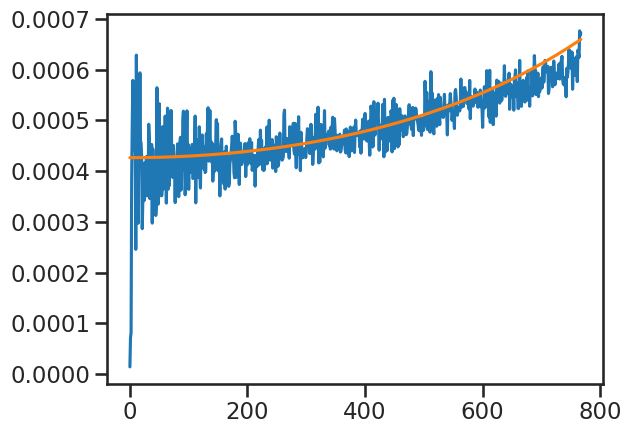

In [43]:
plt.plot(nl[0]/hp.pixwin(256), label = 'anafast')
# plt.plot(nl[0]/hp.pixwin(256), '')
plt.plot(nls/hp.pixwin(256))
# plt.plot(hp.pixwin(256))

In [44]:
cl_unl = camb_clfile(os.path.join(cls_path, 'FFP10_wdipole_lenspotentialCls.dat'))

In [45]:
hp.(cl_unl['tt'])

{'tt': array([0.00000000e+00, 3.15384486e+03, 1.08426834e+03, ...,
        9.66229400e-10, 9.65260803e-10, 9.64292720e-10]),
 'ee': array([0.00000000e+00, 0.00000000e+00, 3.62414129e-02, ...,
        2.00006407e-12, 1.99423451e-12, 1.98828000e-12]),
 'bb': array([0., 0., 0., ..., 0., 0., 0.]),
 'te': array([0.00000000e+00, 0.00000000e+00, 2.93875049e+00, ...,
        1.40842175e-11, 1.40724986e-11, 1.40607859e-11]),
 'pp': array([0.00000000e+00, 5.94954817e-08, 8.92404300e-09, ...,
        7.91637420e-25, 7.91001884e-25, 7.90366882e-25]),
 'pt': array([0.00000000e+00, 6.20759604e-03, 1.28926184e-03, ...,
        2.46796544e-19, 2.46782393e-19, 2.46768224e-19]),
 'pe': array([ 0.00000000e+00,  0.00000000e+00, -5.60260517e-06, ...,
         2.53157091e-22,  2.53085247e-22,  2.53013434e-22])}

In [46]:
map_test = hp.synfast(cl_unl['tt'], nside = 1024)
cls = hp.anafast(map_test)

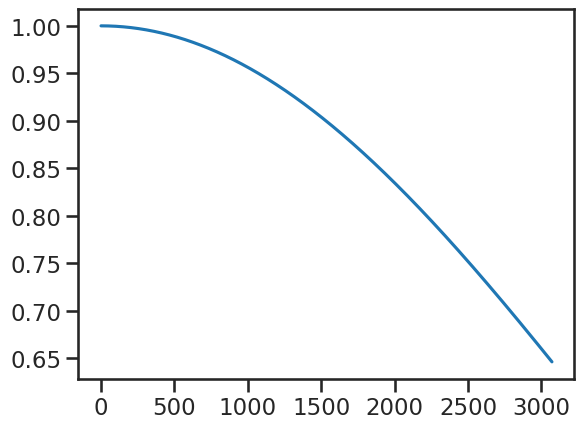

In [51]:
plt.plot(hp.pixwin(1024, lmax = 3*1024))

(1000, 2000)

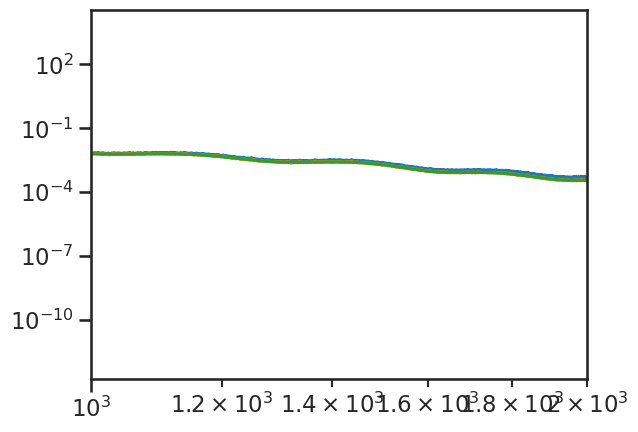

In [57]:
plt.loglog(cls/hp.pixwin(1024, lmax = 3*1024 - 1)**2)
plt.loglog(cls)
plt.loglog(cl_unl['tt'])
plt.xlim(1000, 2000)

# simulations, including HILC

In [13]:
phi_dir = '/pscratch/sd/j/jianyao/data_lensing/simulations/phi_alms/'

phi_name = phi_dir + 'phi_%04d.fits'%0

In [14]:
class simulations:
    
    def __init__(self, nside, instrument, e_n_d = False, mask = None):
        '''
        un-lensed CMB, lensed-CMB, phi, noise are saved to disk
        '''
        
        self.nside = nside
        self.instrument = instrument
        self.fres = instrument['frequency']
        self.fwhms = instrument['fwhm']
        self.end = e_n_d
        
        if mask is None:
            mask = np.ones(12*nside**2)
            
        self.mask = mask
        
    def get_all(self, add_foreground = 'd0', noise = 'alms', use_phi_alm = False, index = 0):

        '''
        return one realization of (lensed CMB + foreground) with the beam applied + noise, 
        for each frequency defined in the instrument. 
        noise: get noise alms or maps. 
        e_n_d: extra noise debias, to generate many noise realizations.
        index: index labelling the realizations
        '''

        cmb_dir = '/pscratch/sd/j/jianyao/data_lensing/simulations/cmb/'
        
        if not os.path.exists(cmb_dir + 'unlensed_CMB_map_%04d.fits'%index):
            
            cl_unl = camb_clfile(os.path.join(cls_path, 'FFP10_wdipole_lenspotentialCls.dat'))
            geom_info = ('healpix', {'nside':self.nside}) # Geometry parametrized as above, this is the default

            lmax_unl = mmax_unl = 3*self.nside
            epsilon = 1e-6

            if use_phi_alm is False:
                cmb_temp = synfast(cl_unl, lmax=lmax_unl, verbose=0, geometry=geom_info, alm = False)
                self.cmb_len = np.row_stack((cmb_temp['T'], cmb_temp['QU'])) # (3, 12*nside**2)

            elif use_phi_alm is True:

                phi_dir = '/pscratch/sd/j/jianyao/data_lensing/simulations/phi_alms/'
                phi_name = phi_dir + 'phi_%04d.fits'%index

                tlm_unl = synalm(cl_unl['tt'], lmax=lmax_unl, mmax=mmax_unl)
                elm_unl = synalm(cl_unl['ee'], lmax=lmax_unl, mmax=mmax_unl)
                blm_unl = synalm(cl_unl['bb'], lmax=lmax_unl, mmax=mmax_unl)

                cmb_unlen = hp.alm2map((tlm_unl, elm_unl, blm_unl), nside = self.nside)
                hp.write_map(cmb_dir + 'unlensed_CMB_map_%04d.fits'%index, cmb_unlen)

                if os.path.exists(phi_name):
                    plm = hp.read_alm(phi_name)

                else:
                    plm = synalm(cl_unl['pp'], lmax=lmax_unl, mmax=mmax_unl)
                    hp.write_alm(phi_name, plm)

                # We then transform the lensing potential into spin-1 deflection field, and deflect the temperature map.
                dlm = almxfl(plm, np.sqrt(np.arange(lmax_unl + 1, dtype=float) * np.arange(1, lmax_unl + 2)), None, False)

                Tlen, Qlen, Ulen = lenspyx.alm2lenmap([tlm_unl, elm_unl, blm_unl], dlm, geometry=geom_info, verbose=0, epsilon=epsilon)

                self.cmb_len = np.row_stack((Tlen, Qlen, Ulen)) 
                
                hp.write_map(cmb_dir + 'lensed_CMB_map_%04d.fits'%index, self.cmb_len)
                
        else:
            self.cmb_len = hp.read_map(cmb_dir + 'lensed_CMB_map_%04d.fits'%index, field = None)

        Nf = self.fres.size
        cmb_maps = np.repeat(self.cmb_len[np.newaxis, :, :], Nf, axis = 0)
        
        ########## simulate noise ##############
        noise_dir = '/pscratch/sd/j/jianyao/data_lensing/simulations/noise/'
        if not os.path.exists(noise_dir + 'noise_freq_%04d.npy'%index):
            noise_maps = get_noise_realization(self.nside, instrument, unit='uK_CMB')
            
            np.save(noise_dir + 'noise_freq_%04d.npy'%index, noise_maps)
            
        else:
            noise_maps = np.load(noise_dir + 'noise_freq_%04d.npy'%index)
            
        noise_alms = []
        
        if self.end is True: 
            noise_maps_end = []
            N = 20
            for n in range(N):
                noise_map_i = get_noise_realization(self.nside, instrument, unit='uK_CMB')
                noise_maps_end.append(noise_map_i)
                
            self.extra_noise = noise_maps_end
            self.N = N
        
        ######## simulate foreground ############
        fg_dir = '/pscratch/sd/j/jianyao/data_lensing/simulations/foreground/'
        if not os.path.exists(fg_dir + 'fg_%s_freq_%04d.npy'%(add_foreground, 0)): # for now, only have one realization for foreground
            
            if add_foreground.startswith('d'):
                # for pysm3 pre-defined models
                sky = pysm3.Sky(nside, preset_strings = [add_foreground])
                foreground = get_observation(instrument, sky = sky, nside=nside, noise=False, unit='uK_CMB')

            elif add_foreground.startswith('forse'):

                pysm_model = add_foreground.split('_')[1]

                foreground = self.rescale_forse(self.fres, pysm_model = pysm_model)

            elif add_foreground == 'no_fore':
                # test case for only noise
                foreground = np.zeros_like(cmb_maps)
                
            np.save(fg_dir + 'fg_%s_freq_%04d.npy'%(add_foreground, 0), foreground)
                              
        else:
            foreground = np.load(fg_dir + 'fg_%s_freq_%04d.npy'%(add_foreground, 0))
                
        map_all = cmb_maps + foreground
        for i in range(Nf):
            # map_all[i] = pysm3.apply_smoothing_and_coord_transform(map_all[i], fwhm=self.fwhms[i]*u.arcmin) + self.noise_maps[i]
            map_all[i] = hp.smoothing(map_all[i], fwhm = self.fwhms[i]/180/60*np.pi) + noise_maps[i]
            foreground[i] = hp.smoothing(foreground[i], fwhm = self.fwhms[i]/180/60*np.pi)
            
            if noise == 'alms':
                noise_alms.append(hp.map2alm(np.where(self.mask== 0, hp.UNSEEN, noise_maps[i])))
                
        if noise == 'maps':
            self.noise_maps = np.where(self.mask== 0, hp.UNSEEN, noise_maps)
        elif noise == 'alms':
            self.noise_alms = noise_alms
                
        self.map_all = np.where(self.mask== 0, hp.UNSEEN, map_all)
        self.fg = np.where(self.mask== 0, hp.UNSEEN, foreground)
        
    def rescale_forse(self, fres, pysm_model = 'd0'):
        '''
        Possible problem: hp.udgrade is used for nside changes; better choice: pysm3.apply_smoothing_and_coord_transform
        '''
                
        my_dust = self.model_forse(pysm_model)
            
        if fres.size > 1:
            _observations = np.zeros((len(fres), 3, 12*self.nside**2))
            for i in range(len(fres)):
                _observations[i] = my_dust.get_emission(fres[i] * u.GHz)*convert_units('uK_RJ', 'uK_CMB', fres[i])
                
        else:
            assert fres.size == 1
            _observations = my_dust.get_emission(fres * u.GHz)*convert_units('uK_RJ', 'uK_CMB', fres)
        
        return _observations
    
    def apply_hilc(self, components, lbins):
        
        '''
        apply fgbuster.hilc method to get clean CMB map
        '''
        
        results = hilc(components, self.instrument, self.map_all, lbins) 
        ### data are deconvolved when transforming to alms, 
        ### then using harmonic_ilc_alm to do the component separation
        weighted_alms = []
        noise_alms_ilc = []
        
        for i in range(self.fres.size):
            bl = hp.gauss_beam(np.radians(self.fwhms[i]/60.0), lmax = lbins[-1], pol=True)
            # all_alms = hp.map2alm(self.map_all[i], lmax = lbins[-1])
            fg_alms = hp.map2alm(self.fg[i], lmax = lbins[-1])
            noise_alm = hp.map2alm(self.noise_maps[i], lmax = lbins[-1])
            
            for j in range(3): # T, E, B
                # hp.almxfl(all_alms[j], results.W[j, :, 0, i]/bl[:, j], inplace = True)  ### to mimic the HILC method: simulated total maps are deconvolved
                hp.almxfl(fg_alms[j], results.W[j, :, 0, i]/bl[:, j], inplace = True)
                hp.almxfl(noise_alm[j], results.W[j, :, 0, i]/bl[:, j], inplace = True)  ### simulated ilc noise maps are not deconvolved during the component separation
                
            # weighted_alms.append(all_alms)
            weighted_alms.append(fg_alms)
            noise_alms_ilc.append(noise_alm)
            
        fg_ilc_alms = np.sum(weighted_alms, axis = 0)
        # cmb_alms = np.sum(weighted_alms, axis = 0)
        noise_ilc_alms = np.sum(noise_alms_ilc, axis = 0) 
        
        if self.end is True:
            nls = []
            for n in range(self.N):
                _noise_alms_ilc = []

                for i in range(self.fres.size):
                    bl = hp.gauss_beam(np.radians(self.fwhms[i]/60.0), lmax = lbins[-1], pol=True)

                    _noise_alm_i = hp.map2alm(self.extra_noise[n][i], lmax = lbins[-1])

                    for j in range(3):
                        hp.almxfl(_noise_alm_i[j], results.W[j, :, 0, i]/bl[:, j], inplace = True)

                    _noise_alms_ilc.append(_noise_alm_i)

                _noise_alms = np.sum(_noise_alms_ilc, axis = 0) 
                nls.append(hp.alm2cl(_noise_alms))

            return results, noise_ilc_alms, fg_ilc_alms, nls
        else:

            return results, noise_ilc_alms, fg_ilc_alms
    
    def model_forse(self, pysm_model):
        
        dust_dir = "/pscratch/sd/j/jianyao/data_lensing/processed_dust_maps/"
        if pysm_model == 'd0':
            my_dust = pysm3.ModifiedBlackBody(
                nside = self.nside,
                map_I = "pysm_2/dust_t_new.fits",
                map_Q = dust_dir + "forse_dust_Q_353GHz_deconvolved_lmax_4096_nside4096_uK_RJ.fits", #"forse_dust_Q_353GHz_3amin_nside4096_uK_RJ.fits",
                map_U = dust_dir + "forse_dust_U_353GHz_deconvolved_lmax_4096_nside4096_uK_RJ.fits",
                unit_I = "uK_RJ",
                unit_Q = "uK_RJ",
                unit_U = "uK_RJ",
                map_mbb_index = 1.54,
                map_mbb_temperature = 20,
                unit_mbb_temperature = "K",
                freq_ref_I = "545 GHz",
                freq_ref_P = "353 GHz"
            )
            
        if pysm_model == 'd1':
            my_dust = pysm3.ModifiedBlackBody(
                nside = self.nside,
                map_I = "pysm_2/dust_t_new.fits",
                map_Q = dust_dir + "forse_dust_Q_353GHz_deconvolved_lmax_4096_nside4096_uK_RJ.fits",
                map_U = dust_dir + "forse_dust_U_353GHz_deconvolved_lmax_4096_nside4096_uK_RJ.fits",
                unit_I = "uK_RJ",
                unit_Q = "uK_RJ",
                unit_U = "uK_RJ",
                map_mbb_index = "pysm_2/dust_beta.fits",
                map_mbb_temperature = "pysm_2/dust_temp.fits",
                unit_mbb_temperature = "K",
                freq_ref_I = "545 GHz",
                freq_ref_P = "353 GHz"
            )
            
        if pysm_model == 'd9':
            my_dust = pysm3.ModifiedBlackBody(
                nside = self.nside,
                map_I = "pysm_2/dust_t_new.fits",
                map_Q = dust_dir + "forse_dust_Q_353GHz_deconvolved_lmax_4096_nside4096_uK_RJ.fits",
                map_U = dust_dir + "forse_dust_U_353GHz_deconvolved_lmax_4096_nside4096_uK_RJ.fits",
                unit_I = "uK_RJ",
                unit_Q = "uK_RJ",
                unit_U = "uK_RJ",
                map_mbb_index = 1.48,
                map_mbb_temperature = 19.6,
                unit_mbb_temperature = "K",
                freq_ref_I = "353 GHz",
                freq_ref_P = "353 GHz"
            )

        if pysm_model == 'd10':
            my_dust = pysm3.ModifiedBlackBody(
                nside = self.nside,
                map_I = "pysm_2/dusts_t_new.fits",
                map_Q = dust_dir + "forse_dust_Q_353GHz_deconvolved_lmax_4096_nside4096_uK_RJ.fits",
                map_U = dust_dir + "forse_dust_U_353GHz_deconvolved_lmax_4096_nside4096_uK_RJ.fits",
                unit_I = "uK_RJ",
                unit_Q = "uK_RJ",
                unit_U = "uK_RJ",
                map_mbb_index = "dust_gnilc/gnilc_dust_beta_nside{nside}_2023.06.06.fits",
                map_mbb_temperature = "dust_gnilc/gnilc_dust_Td_nside{nside}_2023.06.06.fits",
                unit_mbb_temperature = "K",
                freq_ref_I = "353 GHz",
                freq_ref_P = "353 GHz"
            )

        if pysm_model == 'Gaussiand0':
            # print('Gaussian d0 model!')
            my_dust = pysm3.ModifiedBlackBody(
                nside = self.nside,
                map_I = "pysm_2/dust_t_new.fits",
                map_Q = dust_dir + "Gaussian_forse_dust_Q_353GHz_deconvolved_lmax_4096_nside4096_uK_RJ.fits",
                map_U = dust_dir + "Gaussian_forse_dust_U_353GHz_deconvolved_lmax_4096_nside4096_uK_RJ.fits",
                unit_I = "uK_RJ",
                unit_Q = "uK_RJ",
                unit_U = "uK_RJ",
                map_mbb_index = 1.54,
                map_mbb_temperature = 20,
                unit_mbb_temperature = "K",
                freq_ref_I = "545 GHz",
                freq_ref_P = "353 GHz"
            )
            
        if pysm_model == 'Gaussiand1':
            # print('Gaussian d1 model!')
            my_dust = pysm3.ModifiedBlackBody(
                nside = self.nside,
                map_I = "pysm_2/dust_t_new.fits",
                map_Q = dust_dir + "Gaussian_forse_dust_Q_353GHz_deconvolved_lmax_4096_nside4096_uK_RJ.fits",
                map_U = dust_dir + "Gaussian_forse_dust_U_353GHz_deconvolved_lmax_4096_nside4096_uK_RJ.fits",
                unit_I = "uK_RJ",
                unit_Q = "uK_RJ",
                unit_U = "uK_RJ",
                map_mbb_index = "pysm_2/dust_beta.fits",
                map_mbb_temperature = "pysm_2/dust_temp.fits",
                unit_mbb_temperature = "K",
                freq_ref_I = "545 GHz",
                freq_ref_P = "353 GHz"
            )

        if pysm_model == 'Gaussiand9':
            # print('Gaussian d9 model!')
            my_dust = pysm3.ModifiedBlackBody(
                nside = self.nside,
                map_I = "pysm_2/dust_t_new.fits",
                map_Q = dust_dir + "Gaussian_forse_dust_Q_353GHz_deconvolved_lmax_4096_nside4096_uK_RJ.fits",
                map_U = dust_dir + "Gaussian_forse_dust_U_353GHz_deconvolved_lmax_4096_nside4096_uK_RJ.fits",
                unit_I = "uK_RJ",
                unit_Q = "uK_RJ",
                unit_U = "uK_RJ",
                map_mbb_index = 1.48,
                map_mbb_temperature = 19.6,
                unit_mbb_temperature = "K",
                freq_ref_I = "353 GHz",
                freq_ref_P = "353 GHz"
            )
            
        if pysm_model == 'Gaussiand10':
            # print('Gaussian d10 model!')
            my_dust = pysm3.ModifiedBlackBody(
                nside = self.nside,
                map_I = "pysm_2/dust_t_new.fits",
                map_Q = dust_dir + "Gaussian_forse_dust_Q_353GHz_deconvolved_lmax_4096_nside4096_uK_RJ.fits",
                map_U = dust_dir + "Gaussian_forse_dust_U_353GHz_deconvolved_lmax_4096_nside4096_uK_RJ.fits",
                unit_I = "uK_RJ",
                unit_Q = "uK_RJ",
                unit_U = "uK_RJ",
                map_mbb_index = "dust_gnilc/gnilc_dust_beta_nside{nside}_2023.06.06.fits",
                map_mbb_temperature = "dust_gnilc/gnilc_dust_Td_nside{nside}_2023.06.06.fits",
                unit_mbb_temperature = "K",
                freq_ref_I = "353 GHz",
                freq_ref_P = "353 GHz"
            )
            
        return my_dust

# lensed CMB + noise only, consider 145GHz only, i.e., the 4th channel

In [33]:
cl_unl = camb_clfile(os.path.join(cls_path, 'FFP10_wdipole_lenspotentialCls.dat'))
data_dir = '/pscratch/sd/j/jianyao/data_lensing/simulations/cmb_noise_only/SO_LAT_145GHz/'

nside = 1024
instrument = get_instrument('SO_LAT')

# add_foreground = 'forse3_d1'

cases = ['no_fore']
for add_foreground in cases:
    
    for mc in range(250, 300):
        sims = simulations(nside, instrument)
        sims.get_all(add_foreground = add_foreground, noise = 'alms', use_phi_alm = True, phi_sim = 'phi_%04d.fits'%mc)

        # sims.map_all[3]
        hp.write_alm(data_dir + 'CMB_noise_alms_from_SO_LAT_145GHz_%s_nside_1024_%04d.fits'%(add_foreground, mc), hp.map2alm(sims.map_all[3]), overwrite = True)
        # hp.write_alm(data_dir + 'Noise_ilc_alms_from_SO_LAT_%s_HILC_lbins_42x50_lmax_2050_nside_1024_%04d.fits'%(add_foreground, mc), noise_ilc_alms, overwrite = True)
        # hp.write_alm(data_dir + 'FG_ilc_alms_from_SO_LAT_%s_HILC_lbins_42x50_lmax_2050_nside_1024_%04d.fits'%(add_foreground, mc), fg_res_alms, overwrite = True)
        

In [16]:
sims.map_all[3]

(6, 3, 12582912)

# HILC

## run HILC

In [16]:
SO_LAT_mask = hp.read_map('/pscratch/sd/j/jianyao/data_lensing/SO_LAT_mask_1024.fits')

In [17]:
cl_unl = camb_clfile(os.path.join(cls_path, 'FFP10_wdipole_lenspotentialCls.dat'))

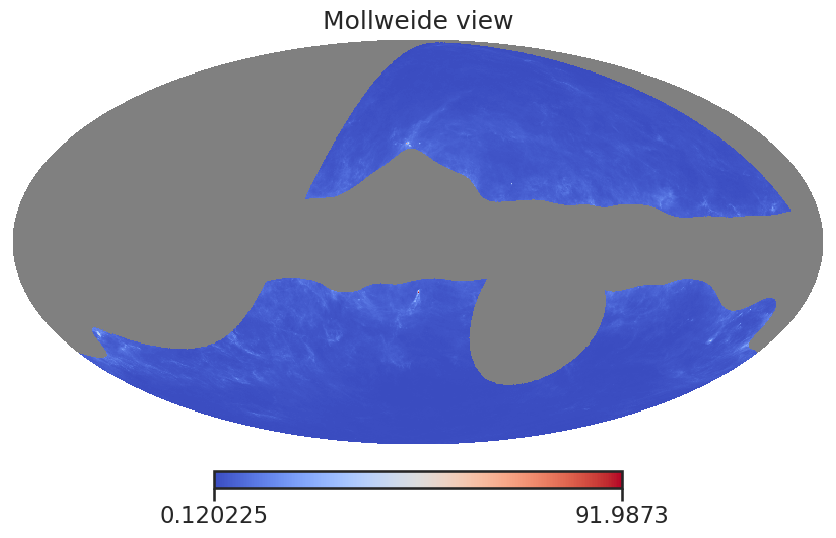

In [76]:
hp.mollview(sims.fg[0][0])

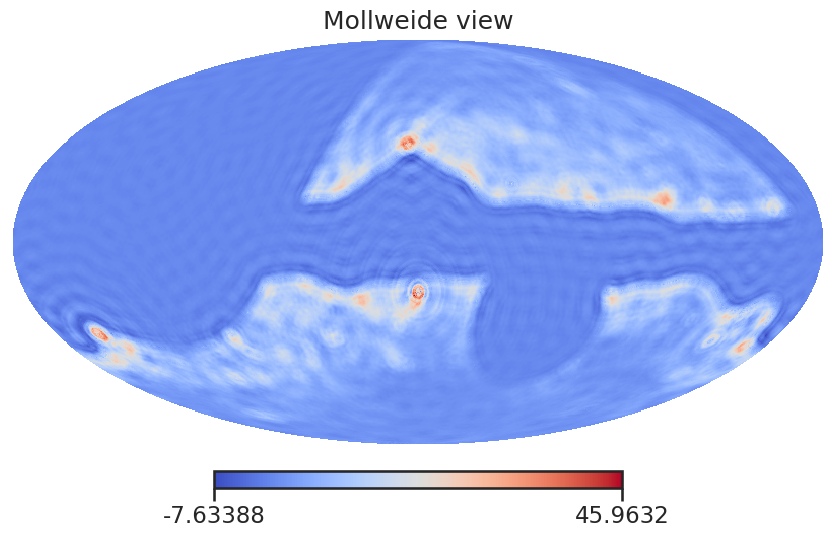

In [72]:
hp.mollview(fg_res_test[0])

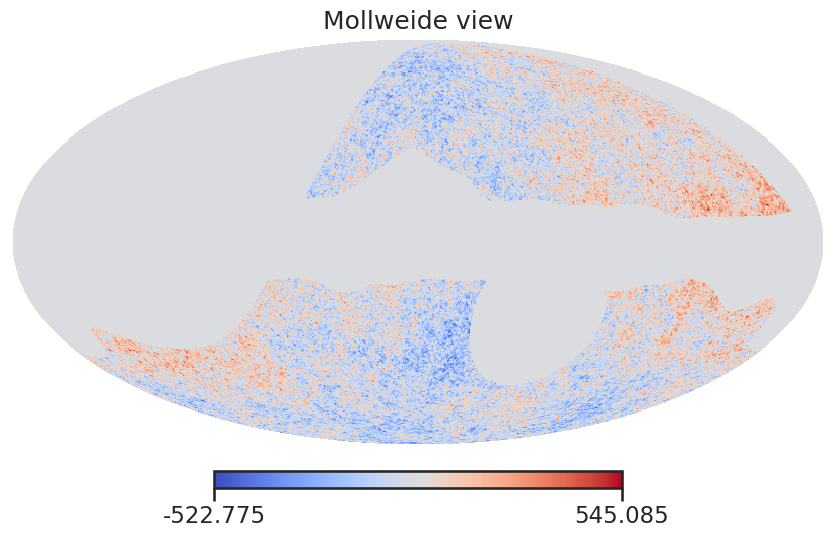

In [69]:
hp.mollview(results.s[0][0])

In [ ]:
nside = 1024
instrument = get_instrument('SO_LAT')
data_dir = '/pscratch/sd/j/jianyao/data_lensing/simulations/cleaned_CMB/SO_LAT_MASK/'
# add_foreground = 'forse3_d1'

# cases = ['d0', 'd1', 'forse3_d0', 'forse3_d1']
# cases = ['forse3_d0']
# cases = ['d10', 'forse3_d9', 'forse3_d0', 'forse3_d1', 'forse3_d10', 'forse3_Gaussiand10']
cases = ['forse3_Gaussiand9']
# cases = ['forse3_Gaussiand9', 'd9', 'forse3_d9']
# cases = ['d9', 'forse3_d9']
# cases = ['d9']
# cases = ['forse3_Gaussiand10', 'd10', 'forse3_d10']
results_all = []
for add_foreground in cases:
    
    sims = simulations(nside, instrument, mask = SO_LAT_mask)
    for mc in range(1, 500):
        
        sims.get_all(add_foreground = add_foreground, noise = 'maps', use_phi_alm = True, index = mc)

        components = [CMB()]
        lbins = np.arange(42)*50

        results, noise_ilc_alms, fg_res_alms = sims.apply_hilc(components, lbins)
        # results_all.append(results)
        hp.write_alm(data_dir + 'CMB_alms_from_SO_LAT_%s_HILC_lbins_42x50_lmax_2050_nside_1024_%04d.fits'%(add_foreground, mc), hp.map2alm(results.s[0], lmax = lbins[-1]), overwrite = True)
        hp.write_alm(data_dir + 'Noise_ilc_alms_from_SO_LAT_%s_HILC_lbins_42x50_lmax_2050_nside_1024_%04d.fits'%(add_foreground, mc), noise_ilc_alms, overwrite = True)
        hp.write_alm(data_dir + 'FG_ilc_alms_from_SO_LAT_%s_HILC_lbins_42x50_lmax_2050_nside_1024_%04d.fits'%(add_foreground, mc), fg_res_alms, overwrite = True)
        

        # plt.figure(figsize = (10, 8))
        # s = 0; e = lbins[-1]
        # coeff = ells*(ells+1)/2/np.pi #*coeff
        # plt.plot(results['cl_out'][0][0][s:e], '--', label = 'TT')
        # plt.loglog(results['cl_out'][0][1][s:e], '--', label = 'EE')
        # plt.loglog(results['cl_out'][0][2][s:e], '--', label = 'BB')
        # plt.loglog(nl[0])
        # plt.loglog(nl[1])
        # plt.loglog(nl[2])

## get the effective beam

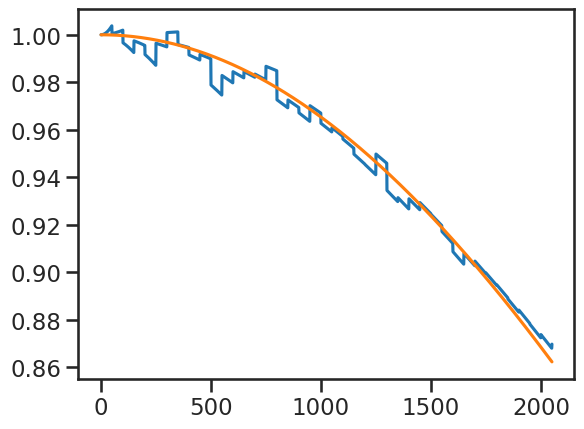

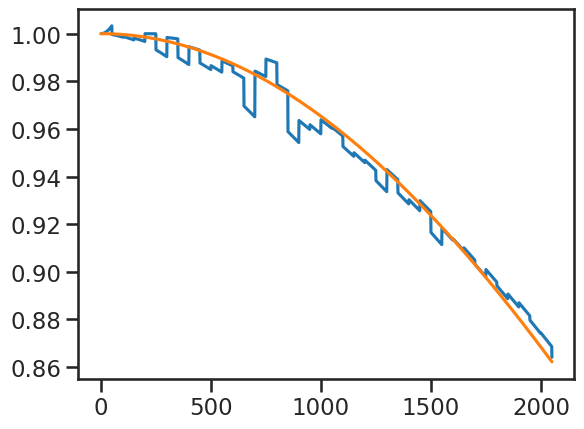

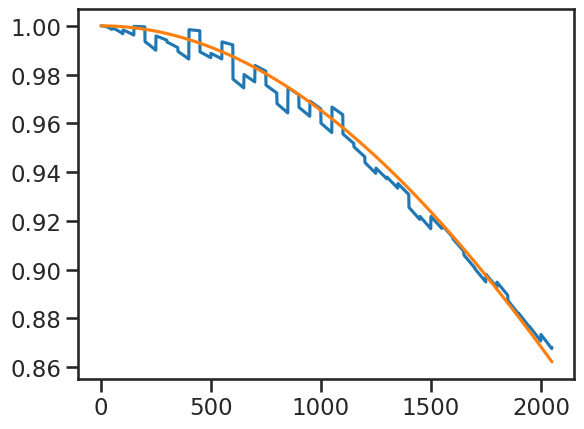

In [55]:

for j in range(len(cases)):
    eff_bl = 0; 
    for i in range(6):
        weights = results_all[j].W[0, :, 0, i]
        bl = hp.gauss_beam(np.radians(instrument['fwhm'][i]/60.0), lmax = lbins[-1])

        eff_bl += weights*bl
    plt.figure()
    plt.plot(eff_bl)
    bl_fit = hp.gauss_beam(np.radians(2.15/60.0), lmax = lbins[-1])
    plt.plot(bl_fit)

## HILC results check

In [27]:
cl_lensed = camb_clfile(os.path.join(cls_path, 'FFP10_wdipole_lensedCls.dat'))

### only noise

In [95]:
nside = 1024
instrument = get_instrument('SO_LAT')

sims = simulations(nside, instrument, e_n_d = True)
sims.get_all(add_foreground = 'no_fore', noise = 'alms')

components = [CMB()]
lbins = np.arange(42)*50

results, noise_ilc_alms, fg_res_alms, nls = sims.apply_hilc(components, lbins)

In [97]:
nl_mean = np.mean(nls, axis = 0)

#### debias with 20 noise realizations

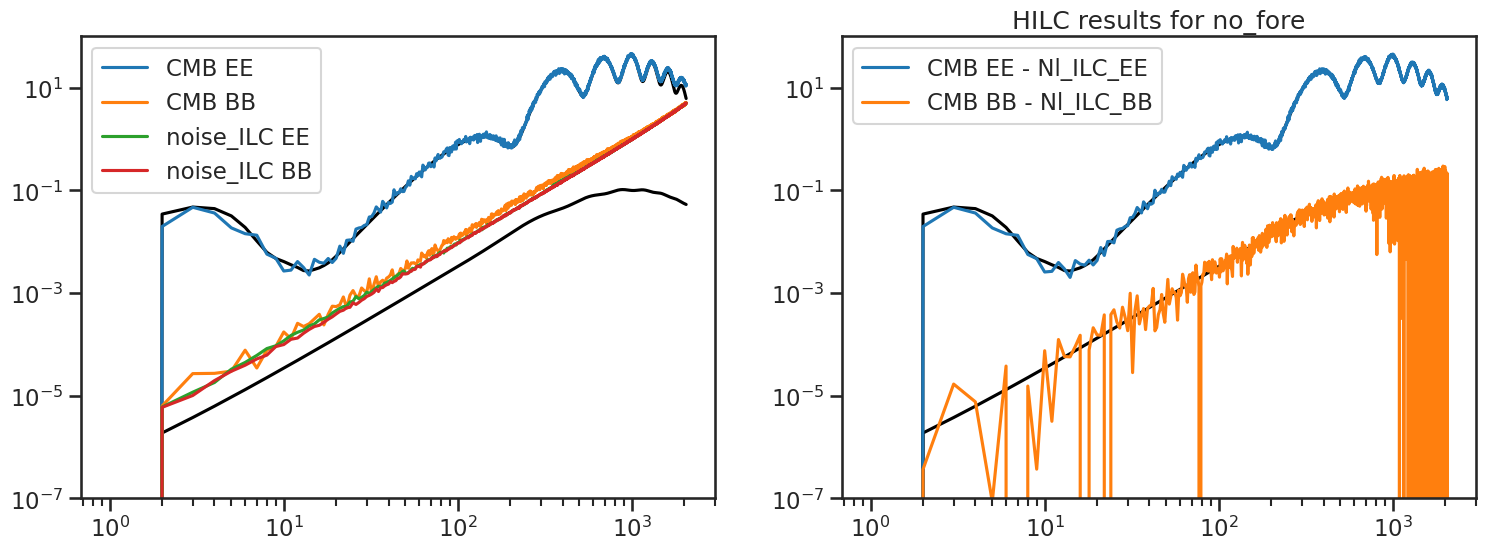

In [101]:
cls = hp.anafast(results.s[0], lmax = 2050)
fg_cls = hp.alm2cl(fg_res_alms)
nl = hp.alm2cl(noise_ilc_alms, lmax = 2050)

fig, axes = plt.subplots(1, 2, figsize = (18, 6))

Ell = lambda ell: ell*(ell+1)/2/np.pi
ells = np.arange(len(cls[0]))

for i in range(2):
    axes[i].loglog(ells, Ell(ells)*cl_lensed['ee'][0:2051], 'k-')
    axes[i].loglog(ells, Ell(ells)*cl_lensed['bb'][0:2051], 'k-')
    axes[i].set_ylim(1e-7, 1e2)

axes[i].set_title('HILC results for %s'%add_foreground)

axes[0].loglog(ells, Ell(ells)*cls[1], label = 'CMB EE')
axes[0].loglog(ells, Ell(ells)*cls[2], label = 'CMB BB')

# axes[0].loglog(ells, Ell(ells)*fg_cls[1], label = 'fg_ILC EE')
# axes[0].loglog(ells, Ell(ells)*fg_cls[2], label = 'fg_ILC BB')

axes[0].loglog(ells, Ell(ells)*nl_mean[1], label = 'noise_ILC EE')
axes[0].loglog(ells, Ell(ells)*nl_mean[2], label = 'noise_ILC BB')

axes[1].loglog(ells, Ell(ells)*(cls[1] - nl_mean[1]), label = 'CMB EE - Nl_ILC_EE')
axes[1].loglog(ells, Ell(ells)*(cls[2] - nl_mean[2]), label = 'CMB BB - Nl_ILC_BB')

for i in range(2):
    axes[i].legend()

####  debias with only one noise realization

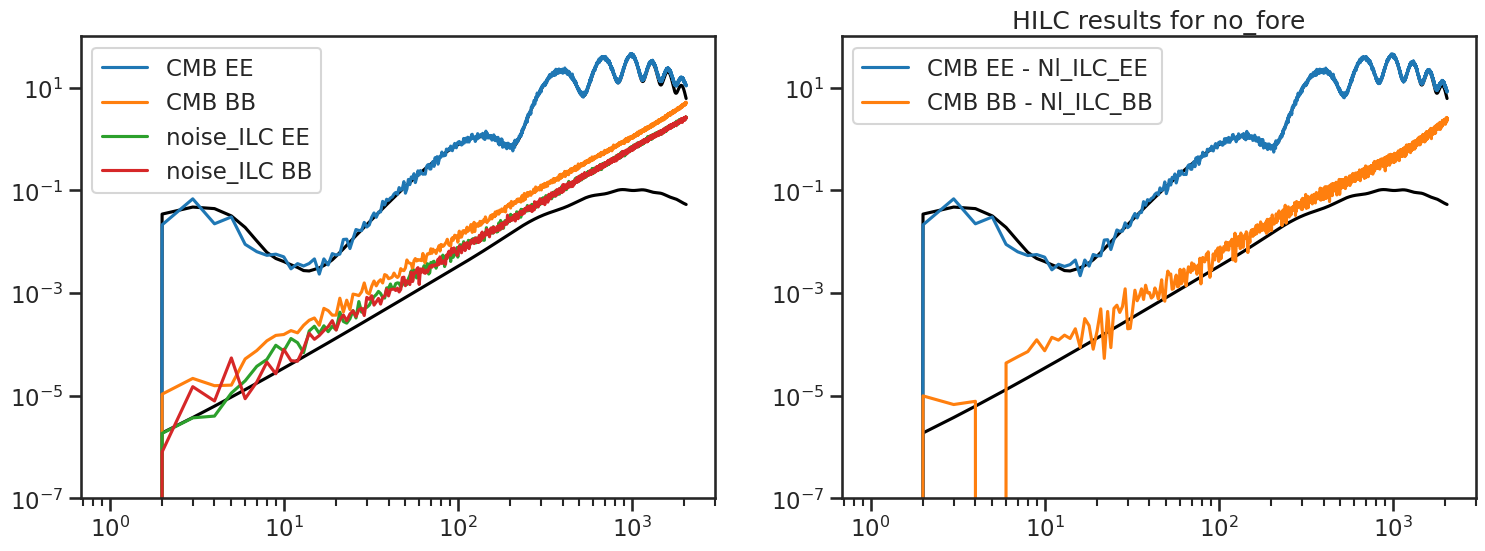

### noise + foreground

In [ ]:
cl_unl = camb_clfile(os.path.join(cls_path, 'FFP10_wdipole_lenspotentialCls.dat'))
data_dir = '/pscratch/sd/j/jianyao/data_lensing/simulations/cmb_noise_only/SO_LAT_145GHz/'

nside = 1024
instrument = get_instrument('SO_LAT')

# add_foreground = 'forse3_d1'

cases = ['no_fore']
for add_foreground in cases:
    
    for mc in range(250, 300):
        sims = simulations(nside, instrument)
        sims.get_all(add_foreground = add_foreground, noise = 'alms', use_phi_alm = True, phi_sim = 'phi_%04d.fits'%mc)

        # sims.map_all[3]
        hp.write_alm(data_dir + 'CMB_noise_alms_from_SO_LAT_145GHz_%s_nside_1024_%04d.fits'%(add_foreground, mc), hp.map2alm(sims.map_all[3]), overwrite = True)
        # hp.write_alm(data_dir + 'Noise_ilc_alms_from_SO_LAT_%s_HILC_lbins_42x50_lmax_2050_nside_1024_%04d.fits'%(add_foreground, mc), noise_ilc_alms, overwrite = True)
        # hp.write_alm(data_dir + 'FG_ilc_alms_from_SO_LAT_%s_HILC_lbins_42x50_lmax_2050_nside_1024_%04d.fits'%(add_foreground, mc), fg_res_alms, overwrite = True)
        

In [18]:
# cases = ['d0', 'd1', 'forse3_d0', 'forse3_d1']
# cases = ['d0', ]
# cases = ['d9', 'd10', 'forse3_d0', 'forse3_d1']
# cases = ['forse3_d9', 'forse3_d10', 'forse3_Gaussiand10']
# cases = ['forse_Gaussiand0', 'forse_Gaussiand1', 'forse_Gaussiand9', 'forse_Gaussiand10']
# cases = ['d10', 'forse3_d9', 'forse3_d0', 'forse3_d1', 'forse3_d10', 'forse3_Gaussiand10']
cases = ['no_fore', 'forse3_Gaussiand9', 'd9', 'forse3_d9']
results_all = []
for add_foreground in cases:

    nside = 1024
    instrument = get_instrument('SO_LAT')

    sims = simulations(nside, instrument, e_n_d = False) # e_n_d = True
    sims.get_all(add_foreground = add_foreground, noise = 'alms', use_phi_alm = True, phi_sim = 'phi_%04d.fits'%0)

    components = [CMB()]
    lbins = np.arange(42)*50
    
    if add_foreground != 'no_fore':
        results_i = sims.apply_hilc(components, lbins)
        results_all.append(results_i)
    
    else:
        results_all.append(sims.noise_alms)
    # cleaned_CMB = hp.read_map('/pscratch/sd/j/jianyao/data_lensing/cleaned_CMB/SO_LAT/CMB_map_from_SO_LAT_%s_HILC_lbins_42x50_lmax_2050_nside_1024_%04d.fits'%(add_foreground, mc), field = None)

Gaussian d9 model!


In [38]:
len(results_all[0])

6

In [23]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

Text(0.5, 0, '$\\ell$')

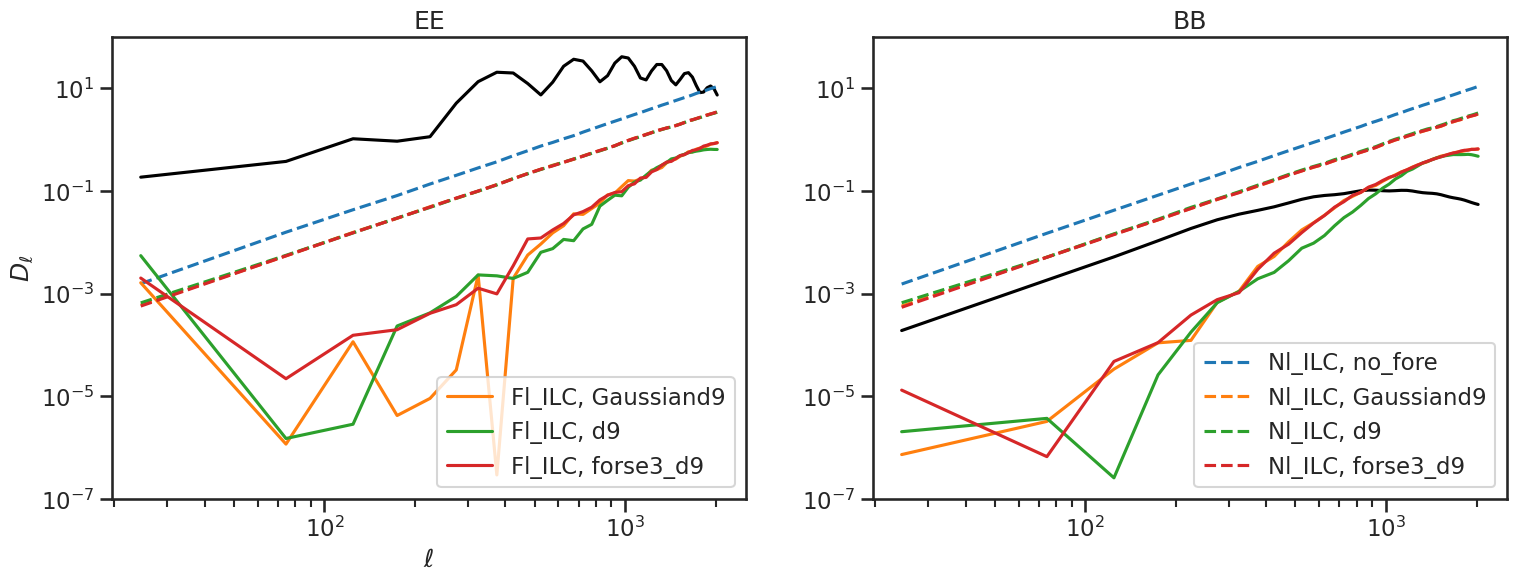

In [50]:
ells, cl_ee = bin_cell(cl_lensed['ee'][0:2051], lmax = 2050, bin_width = 50)
ells, cl_bb = bin_cell(cl_lensed['bb'][0:2051], lmax = 2050, bin_width = 50)

fig, axes = plt.subplots(1, 2, figsize = (18, 6))

# axes[i].set_title('HILC results for %s'%add_foreground)
axes[0].loglog(ells, cl_ee[0], 'k-')
axes[1].loglog(ells, cl_bb[0], 'k-')

axes[0].set_title('EE')
axes[1].set_title('BB')
case_names= ['no_fore', 'Gaussiand9', 'd9', 'forse3_d9']
for c, add_foreground in zip(range(len(cases)), cases):
    
    if c > 0:
        results, noise_ilc_alms, fg_res_alms = results_all[c] # e_n_d = False
        fg_cls = hp.alm2cl(fg_res_alms)
        ells, fl_bin = bin_cell(fg_cls, lmax = 2050, bin_width = 50)
        
    else:
        noise_ilc_alms = results_all[c][3] # consider 145GHz map only
        
    nl = hp.alm2cl(noise_ilc_alms, lmax = 2050)
    _, nl_bin = bin_cell(nl, lmax = 2050, bin_width = 50, ell_2=True)
    for i in range(2):
        
        if c > 0:
            if i == 0:
                axes[i].loglog(ells, fl_bin[i + 1], label = 'Fl_ILC, %s'%case_names[c], color = colors[c], ls = '-')
            else:
                axes[i].loglog(ells, fl_bin[i + 1], color = colors[c], ls = '-')
                
        if i == 0:
            axes[i].loglog(ells, nl_bin[i + 1], color = colors[c], ls = '--')
        else:
            axes[i].loglog(ells, nl_bin[i + 1], label = 'Nl_ILC, %s'%case_names[c], color = colors[c], ls = '--')
            
        axes[i].set_ylim(1e-7, 1e2)

axes[0].legend()
axes[1].legend()
axes[0].set_ylabel(r'$D_{\ell}$')
axes[0].set_xlabel(r'$\ell$')    

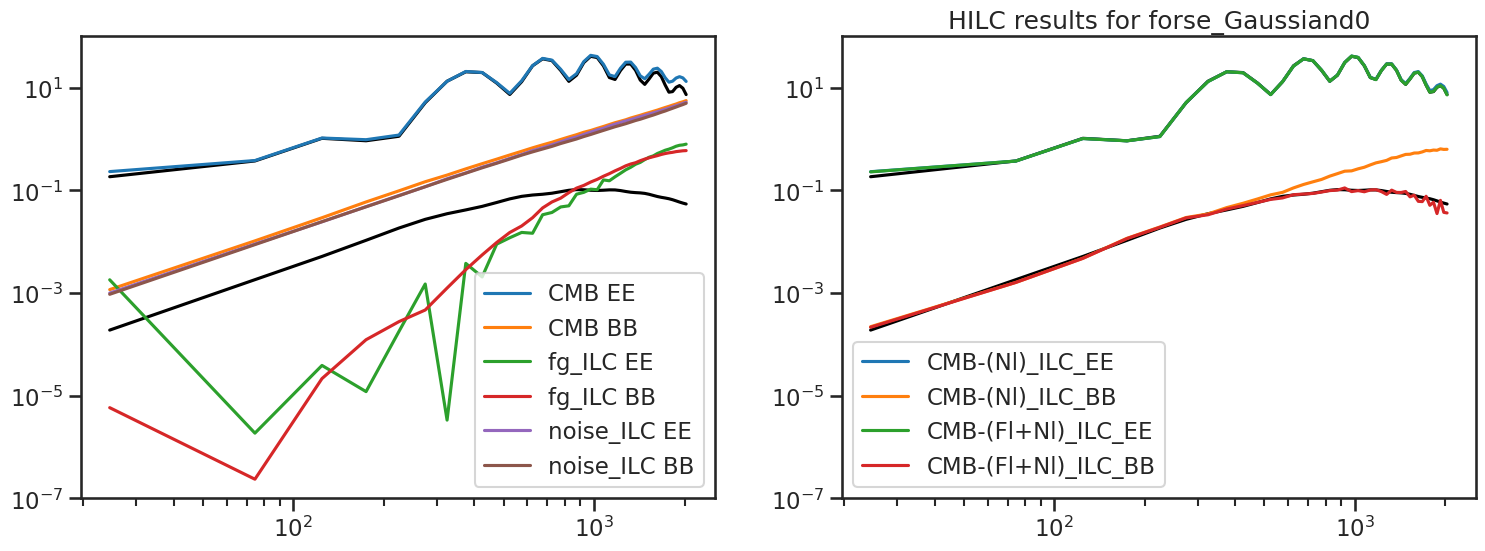

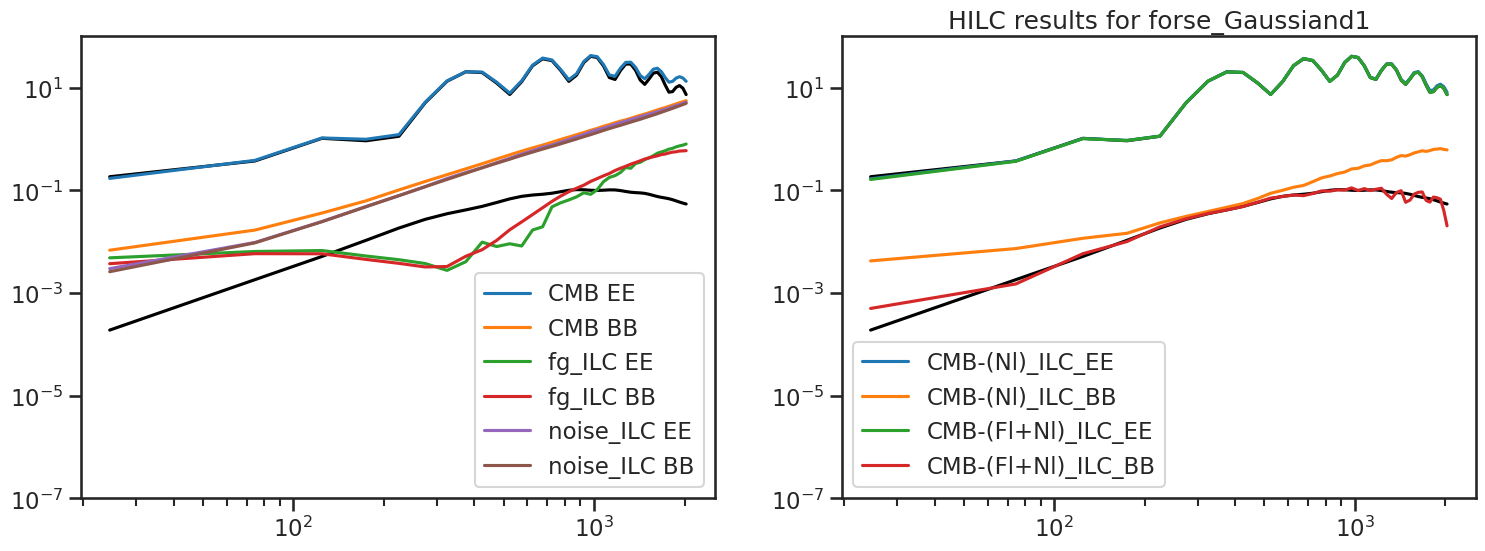

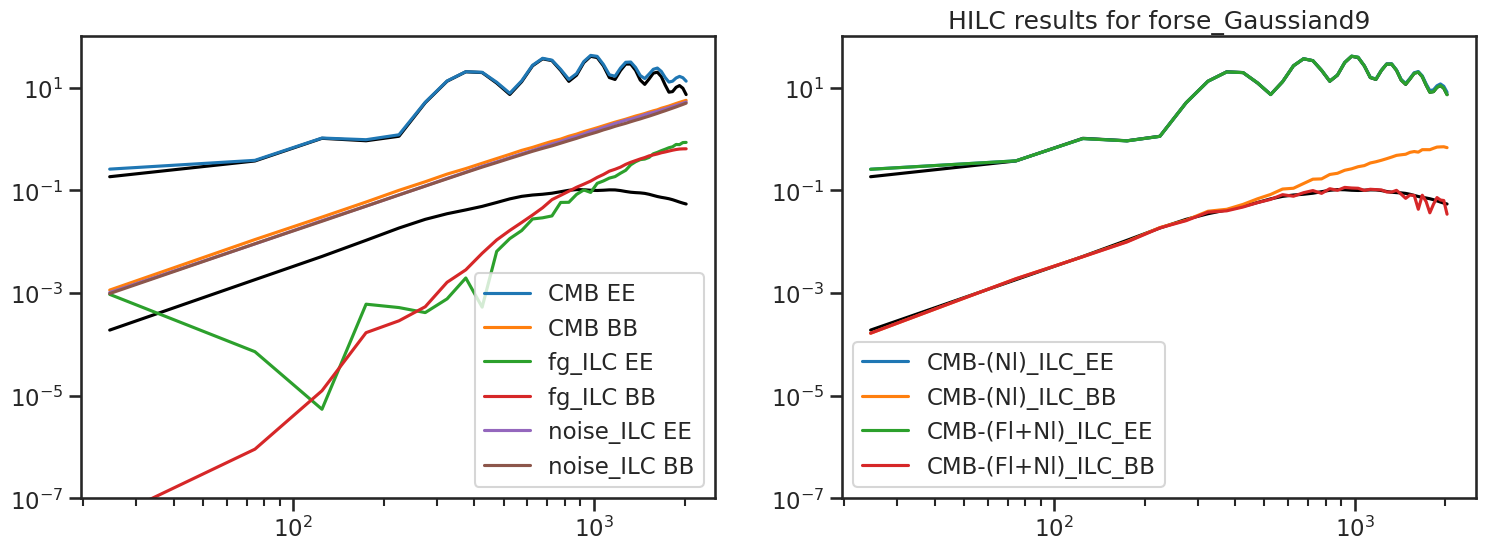

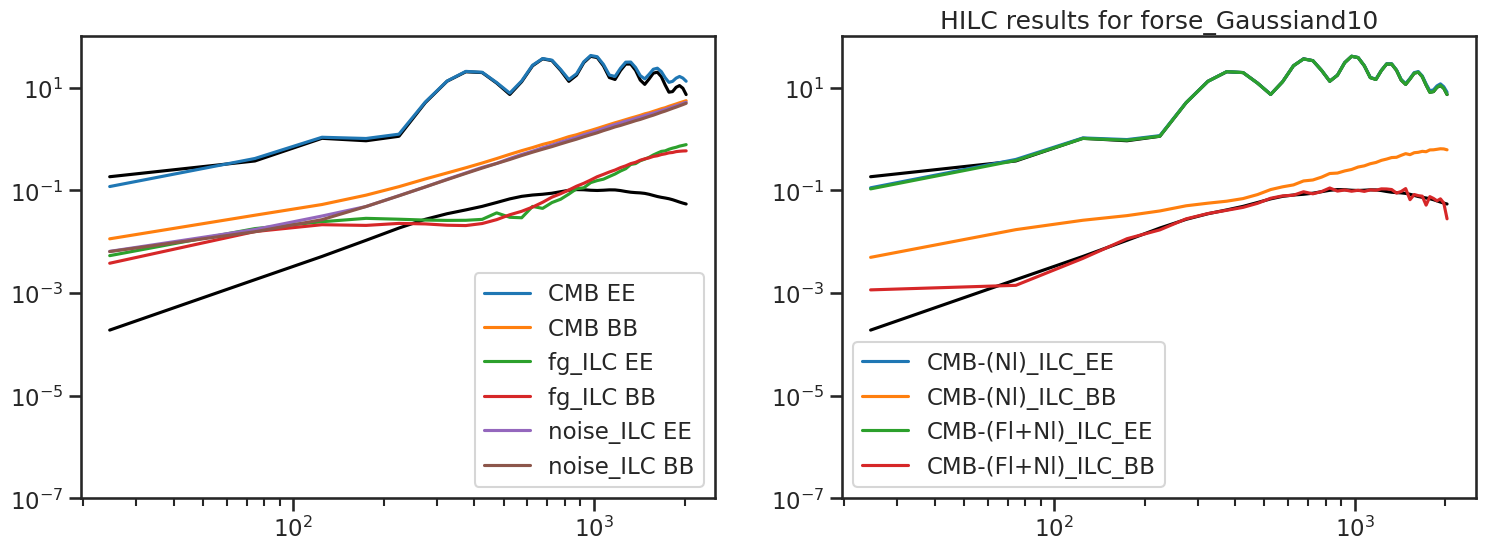

In [18]:
for c, add_foreground in zip(range(len(cases)), cases):

    results, noise_ilc_alms, fg_res_alms, nls = results_all[c] # e_n_d = True

    cls = hp.anafast(results.s[0], lmax = 2050)
    fg_cls = hp.alm2cl(fg_res_alms)
    nl = hp.alm2cl(noise_ilc_alms, lmax = 2050)

    nl_mean = np.mean(nls, axis = 0)
    
    ells, cl_bin = bin_cell(cls, lmax = 2050, bin_width = 50)
    ells, fl_bin = bin_cell(fg_cls, lmax = 2050, bin_width = 50)
    ells, nl_bin = bin_cell(nl_mean, lmax = 2050, bin_width = 50)
    
    ells, cl_ee = bin_cell(cl_lensed['ee'][0:2051], lmax = 2050, bin_width = 50)
    ells, cl_bb = bin_cell(cl_lensed['bb'][0:2051], lmax = 2050, bin_width = 50)
    
    fig, axes = plt.subplots(1, 2, figsize = (18, 6))

    Ell = lambda ell: ell*(ell+1)/2/np.pi
    # ells = np.arange(len(cls[0]))

    for i in range(2):
        axes[i].loglog(ells, cl_ee[0], 'k-')
        axes[i].loglog(ells, cl_bb[0], 'k-')
        axes[i].set_ylim(1e-7, 1e2)

    axes[i].set_title('HILC results for %s'%add_foreground)

    axes[0].loglog(ells, cl_bin[1], label = 'CMB EE')
    axes[0].loglog(ells, cl_bin[2], label = 'CMB BB')

    axes[0].loglog(ells, fl_bin[1], label = 'fg_ILC EE')
    axes[0].loglog(ells, fl_bin[2], label = 'fg_ILC BB')

    axes[0].loglog(ells, nl_bin[1], label = 'noise_ILC EE')
    axes[0].loglog(ells, nl_bin[2], label = 'noise_ILC BB')

    axes[1].loglog(ells, (cl_bin[1] - nl_bin[1]), label = 'CMB-(Nl)_ILC_EE')
    axes[1].loglog(ells, (cl_bin[2] - nl_bin[2]), label = 'CMB-(Nl)_ILC_BB')
    
    axes[1].loglog(ells, (cl_bin[1] - nl_bin[1] - fl_bin[1]), label = 'CMB-(Fl+Nl)_ILC_EE')
    axes[1].loglog(ells, (cl_bin[2] - nl_bin[2] - fl_bin[2]), label = 'CMB-(Fl+Nl)_ILC_BB')

    for i in range(2):
        axes[i].legend()